In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.nn.init as init
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

# from torchinfo import summary

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import random
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time
import math



c:\Users\25678\anaconda3\envs\carRun\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_img_steering_udacity(datadir, data):
    image_path = []
    steering = []
    throttle = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        throttle.append(float(indexed_data[4]))
        # left image append
        image_path.append(os.path.join(datadir,left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        throttle.append(float(indexed_data[4]))
        # right image append
        image_path.append(os.path.join(datadir,right.strip()))
        steering.append(float(indexed_data[3])-0.15)
        throttle.append(float(indexed_data[4]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    throttles = np.asarray(throttle)
    return image_paths, steerings, throttles
 

In [3]:
def load_img_steering_car(datadir, data):
    image_path = []
    steering = []
    throttle = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center = indexed_data[0]+'.png'
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[2]))
        throttle.append(float(indexed_data[1]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    throttles = np.asarray(throttle)
    return image_paths, steerings, throttles

In [4]:
def img_preprocess(img):
    # img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img *= 255
    return img

In [5]:

class DrivingImageDataset(Dataset):
    def __init__(self, image_paths, steering_ang, throttles, transform=None):
        self.img_paths = image_paths
        self.steering_angs = steering_ang
        self.transform = transform
        self.throttles = throttles

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = mpimg.imread(img_path)
        img = img_preprocess(img)
        img = img.astype(np.uint8)
        steering = self.steering_angs[index]
        throttle = self.throttles[index]

        if self.transform is not None:
            img = self.transform(img)
            # img = img.to(dtype=torch.long)
            steering = torch.tensor(steering)
            steering = torch.tensor([steering.to(dtype=torch.float32)])
            throttle = torch.tensor(throttle)
            throttle = torch.tensor([throttle.to(dtype=torch.float32)])

        # print('steering: ',steering.shape)
        return img, steering, throttle

In [6]:

class nvidia_model(nn.Module):
    in_planes = [3, 24, 36, 48, 64, 64, 1152, 100, 50, 10, 2]
    kernel_size = [5, 5, 5, 3, 3]
    dropout_p = [0.45, 0.4, 0.4]
    def __init__(self):
        super(nvidia_model, self).__init__()
        self.bn1 = nn.BatchNorm2d(3)
        self.conv1 = nn.Conv2d(self.in_planes[0], self.in_planes[1], self.kernel_size[0], stride=2)
        self.conv2 = nn.Conv2d(self.in_planes[1], self.in_planes[2], self.kernel_size[1], stride=2)
        self.conv3 = nn.Conv2d(self.in_planes[2], self.in_planes[3], self.kernel_size[2], stride=2)
        self.conv4 = nn.Conv2d(self.in_planes[3], self.in_planes[4], self.kernel_size[3])
        self.conv5 = nn.Conv2d(self.in_planes[4], self.in_planes[5], self.kernel_size[4])
        self.dropout1 = nn.Dropout(p=self.dropout_p[0])
        self.fc1 = nn.Linear(self.in_planes[6], self.in_planes[7])
        self.dropout2 = nn.Dropout(p=self.dropout_p[1])
        self.fc2 = nn.Linear(self.in_planes[7], self.in_planes[8])
        self.dropout3 = nn.Dropout(p=self.dropout_p[2])
        self.fc3 = nn.Linear(self.in_planes[8], self.in_planes[9])
        self.output = nn.Linear(self.in_planes[9], self.in_planes[10])

    # def print_layer(self, layer):
    #     print(layer.shape)
    #     print(type(layer))

    def forward(self, x):
        # self.print_layer(x)
        out = self.bn1(x)
        # self.print_layer(out)
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = F.relu(self.conv4(out))
        out = F.relu(self.conv5(out))
        out = self.dropout1(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = self.dropout2(out)
        out = F.relu(self.fc2(out))
        out = self.dropout3(out)
        out = F.relu(self.fc3(out))
        out = self.output(out)
        return out



In [7]:
TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
term_width = 80 

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [8]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    # Setup time measurement for training epoch
    _tTrainAcc = 0
    _cnt = 0
    _topAccu = 0
    _tCommAccu = 0
    _tComputeAccu = 0
    _tBegin = time.perf_counter()

    for batch_idx, (inputs, target_steering, target_throttle) in enumerate(trainloader):
        # print(inputs.shape)
        # break
        
        _cnt += 1
        _tTrainStart = time.perf_counter()
        inputs, target_steering, target_throttle = inputs.to(device), target_steering.to(device), target_throttle.to(device)
        # print('Finish Copying data into GPU')
        # print('Test: ',targets.shape)
        # print(inputs.dtype)
        optimizer.zero_grad()
        res = net(inputs)
        steering = torch.unsqueeze(res[:, 0], 0).T
        throttle = torch.unsqueeze(res[:, 1], 0).T
        loss_steering = criterion(steering, target_steering)
        loss_throttle = criterion(throttle, target_throttle)
        loss = loss_steering + loss_throttle

        _tCommStart = time.perf_counter()
        loss.backward()
        optimizer.step()
        # torch.cuda.synchronize()
        
        _tTrainEnd = time.perf_counter()

        train_loss += loss.item()
        total += target_steering.size(0)

        if not verboseFlag:
            progress_bar(batch_idx, len(trainloader), 'Loss: %.5f'
                    % (train_loss/(batch_idx+1)))
        _tTrainAcc += _tTrainEnd - _tTrainStart
        _tCommAccu += _tTrainEnd- _tCommStart
        _tComputeAccu += _tCommStart - _tTrainStart

    _tEnd = time.perf_counter()
    totalTime = _tEnd - _tBegin
    trainTime = _tTrainAcc
    commTime = _tCommAccu
    computeTime = _tComputeAccu
    loadTime = totalTime - trainTime
    return train_loss / _cnt, trainTime, totalTime, loadTime, commTime, computeTime

        



In [9]:
def test(epoch):
    global best_loss
    net.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (inputs, target_steering, target_throttle) in enumerate(testloader):
            inputs, target_steering, target_throttle = inputs.to(device), target_steering.to(device), target_throttle.to(device)

            res = net(inputs)
            steering = torch.unsqueeze(res[:, 0], 0).T
            throttle = torch.unsqueeze(res[:, 1], 0).T
            loss_steering = criterion(steering, target_steering)
            loss_throttle = criterion(throttle, target_throttle)
            loss = loss_steering + loss_throttle

            test_loss += loss.item()

        if not verboseFlag:
            progress_bar(batch_idx, len(testloader), 'Loss: %.5f'
                    % (test_loss/(batch_idx+1)))

    # Save checkpoint.
    if test_loss < best_loss:
        print('Saving..')
        state = {
            'net': net.module.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_loss = test_loss

In [10]:
# model = nvidia_model()
# summary(model, (3,66,200), batch_size=500)

In [11]:
def load_data_udacity(datadir):
    columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
    data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
    pd.set_option('display.max_colwidth', None)
    data.head()
    num_bins = 25
    samples_per_bin = 600
    hist, bins = np.histogram(data['steering'], num_bins)
    center = (bins[:-1]+bins[1:]) * 0.5
    plt.bar(center, hist, width = 0.05)
    plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))
    
    
    print('total data', len(data))

    remove_list = []
    for j in range(num_bins):
        list_ = []
        for i in range(len(data['steering'])):
            if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
                list_.append(i)
        list_ = shuffle(list_)
        list_ = list_[samples_per_bin:]
        remove_list.extend(list_)
        
    print('removed', len(remove_list))
    data.drop(data.index[remove_list], inplace = True)
    print('remaining', len(data))

    # hist, _ = np.histogram(data['steering'], (num_bins))
    # plt.bar(center, hist, width = 0.05)
    # plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))
    return data

In [12]:
def load_data_car(datadir):
    columns = ['center', 'throttle', 'steering']
    data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
    pd.set_option('display.max_colwidth', None)
    data.head()
    num_bins = 25
    samples_per_bin = 600
    hist, bins = np.histogram(data['steering'], num_bins)
    # center = (bins[:-1]+bins[1:]) * 0.5
    # plt.bar(center, hist, width = 0.05)
    # plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))
    
    
    print('total data', len(data))

    remove_list = []
    for j in range(num_bins):
        list_ = []
        for i in range(len(data['steering'])):
            if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
                list_.append(i)
        list_ = shuffle(list_)
        list_ = list_[samples_per_bin:]
        remove_list.extend(list_)
        
    print('removed', len(remove_list))
    data.drop(data.index[remove_list], inplace = True)
    print('remaining', len(data))

    # hist, _ = np.histogram(data['steering'], (num_bins))
    # plt.bar(center, hist, width = 0.05)
    # plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin,samples_per_bin))
    return data

In [13]:

# def gen_Dataset(Dir, batch):
#     transform_train = transforms.Compose([
#         # transforms.RandomCrop(32, padding=4),
#         # transforms.RandomHorizontalFlip(),
#         transforms.ToPILImage(),
#         transforms.ToTensor()
#     ])

#     transform_valid = transforms.Compose([
#         transforms.ToTensor()
#     ])
#     data = load_data(Dir)
#     image_paths, steerings, throttles = load_img_steering(Dir + '/IMG', data)
#     # X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, throttles, test_size=0.2)
#     X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, throttles, test_size=0.2)
#     print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
#     Q = math.floor(len(X_train)/batch)
#     trainset = DrivingImageDataset(X_train, y_train, transform_train)
#     testset = DrivingImageDataset(X_valid, y_valid, transform_valid)
#     return trainset, testset
    

In [14]:

def gen_Dataset(Dir):
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToPILImage(),
        transforms.ToTensor(),
    ])

    transform_valid = transforms.Compose([
        transforms.ToTensor()
    ])
    data = load_data_car(Dir)
    image_paths, steerings, throttles = load_img_steering_car(Dir + '/IMG', data)
    train_idx, val_idx = train_test_split(list(range(len(image_paths))), test_size=0.2)
    X_train = image_paths[train_idx]
    X_valid = image_paths[val_idx]
    steerings_train = steerings[train_idx]
    steerings_valid = steerings[val_idx]
    throttles_train = throttles[train_idx]
    throttles_valid = throttles[val_idx]
    print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
    trainset = DrivingImageDataset(X_train,steerings_train, throttles_train, transform_train)
    testset = DrivingImageDataset(X_valid, steerings_valid, throttles_valid, transform_valid)
    return trainset, testset

In [15]:
def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal_(m.weight, mode='fan_out')
            # if m.bias:
            #     init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal_(m.weight, std=1e-3)
            # if m.bias:
            #     init.constant_(m.bias, 0)

In [16]:

if __name__ == "__main__":
    datadir = '3'
    verboseFlag = False
    batch = 100
    epochs = 200
    worker_nums = 0
    best_loss = 1000
    print('==> Preparing Data')
    trainset, testset = gen_Dataset(datadir)
    
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size = batch, shuffle=True, num_workers=worker_nums
    )

    testloader = torch.utils.data.DataLoader(
        testset, batch_size = 100, shuffle=True, num_workers=worker_nums
    )

    print('==> Building Model')
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'
    print('Start training using', device)
        
    net = nvidia_model()
    init_params(net)
    # net = net.double()
    # summary(net)
    net = net.to(device)
    if device == 'cuda':
        net =torch.nn.DataParallel(net)
        cudnn.benchmark = True
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    perf_list = []
    for epoch in range(0, epochs):
        trainPerf = train(epoch)
        test(epoch)
        scheduler.step()
        perf_list.append(trainPerf)

    
    


==> Preparing Data
total data 367
removed 0
remaining 367
Training Samples: 293
Valid Samples: 74
==> Building Model
Start training using cuda

Epoch: 0
 [===========================================>.....................]  Step: 1s508ms | Tot: 2s836ms | Loss: 0.554 3/3 
 [>................................................................]  Step: 1s39ms | Tot: 0ms | Loss: 0.614 1/1 
Saving..

Epoch: 1
 [===========================================>.....................]  Step: 1s303ms | Tot: 2s918ms | Loss: 0.551 3/3 
 [>................................................................]  Step: 1s82ms | Tot: 0ms | Loss: 0.608 1/1 
Saving..

Epoch: 2
 [===========================================>.....................]  Step: 1s238ms | Tot: 2s717ms | Loss: 0.547 3/3 
 [>................................................................]  Step: 997ms | Tot: 0ms | Loss: 0.603 1/1 
Saving..

Epoch: 3
 [===========================================>.....................]  Step: 1s452ms | Tot: 2s798ms

In [29]:
state = {
    'net': net.module.state_dict(),
    'optimizer': optimizer.state_dict()
}
if not os.path.isdir('checkpoint'):
    os.mkdir('checkpoint')
torch.save(state, './checkpoint/ckpt.pth')

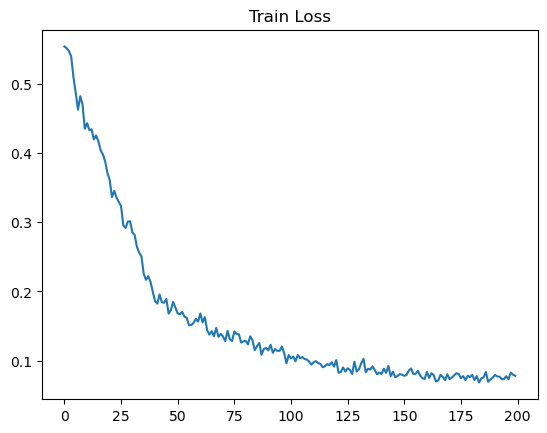

In [25]:
loss_list = []

for perf in perf_list:
    loss_list.append(perf[0])


plt.plot(loss_list)
plt.title('Train Loss')
plt.show()

torch.Size([100, 3, 66, 200])
tensor([[ 0.2591, -0.9048],
        [ 0.2191, -0.7960],
        [ 0.2125,  0.4729],
        [ 0.2452,  0.6302],
        [ 0.2431,  0.6201],
        [ 0.1454,  0.1064],
        [ 0.2018,  0.4212],
        [ 0.1907,  0.3678],
        [ 0.1154, -0.5148],
        [ 0.1625, -0.6427],
        [ 0.1898,  0.3632],
        [ 0.2462,  0.6350],
        [ 0.2416,  0.6123],
        [ 0.2060,  0.4413],
        [ 0.1572, -0.6283],
        [ 0.1072, -0.0346],
        [ 0.1662, -0.5017],
        [ 0.2557,  0.6802],
        [ 0.2033, -0.7533],
        [ 0.2092, -0.7687],
        [ 0.2324, -0.8323],
        [ 0.2509, -0.8826],
        [ 0.2039,  0.4312],
        [ 0.0903, -0.4457],
        [ 0.1882,  0.3560],
        [ 0.2167, -0.7897],
        [ 0.2171, -0.7911],
        [ 0.2266, -0.8166],
        [ 0.0986, -0.3232],
        [ 0.2142,  0.4809],
        [ 0.1372, -0.5739],
        [ 0.1640, -0.6467],
        [ 0.2102,  0.4616],
        [ 0.0983, -0.4682],
        [ 0.2090, 

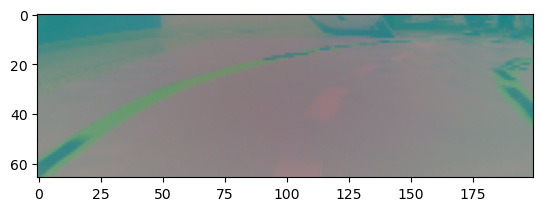

In [30]:
dataiter = iter(trainloader)
net.eval()
inputs, steering, throttle = next(dataiter)
out = net(inputs.to(device))
print(inputs.shape)
print(out)
# print(steering)
plt.imshow(inputs[10].permute(1, 2, 0))

In [ ]:
device_batch = torch.device('cuda')
PATH = './checkpoint/ckpt.pth'
net_batch = nvidia_model()
net_batch = net_batch.to(device_batch)
optimizer_batch = optim.Adam(net.parameters(), lr=1e-3, weight_decay=5e-4)
checkpoint = torch.load(PATH, map_location=device)
net_batch.load_state_dict(checkpoint['net'])
optimizer_batch.load_state_dict(checkpoint['optimizer'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


In [27]:
net.eval()
img_path_batch = np.asarray(['3/IMG/1669859276_3.png', '3/IMG/1669859310_8.png'])
steer_list = np.ones(len(img_path_batch))
throttle_list = np.ones(len(img_path_batch))

transform_batch = transforms.Compose([
    transforms.ToTensor()
])

test_batch_dataset = DrivingImageDataset(img_path_batch, steer_list, throttle_list, transform_batch)
test_batch_loader = torch.utils.data.DataLoader(
    test_batch_dataset, batch_size = 1, num_workers=worker_nums
)

print(test_batch_dataset[0][0].shape)


torch.Size([3, 66, 200])


predicted: throttle  0.2372482270002365 steering -0.8453515768051147
predicted: throttle  0.20297974348068237 steering 0.4268628656864166


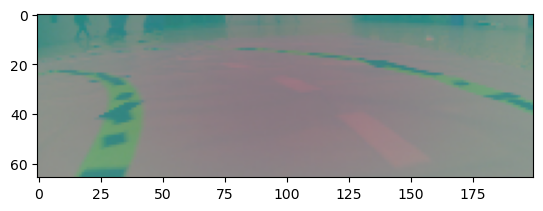

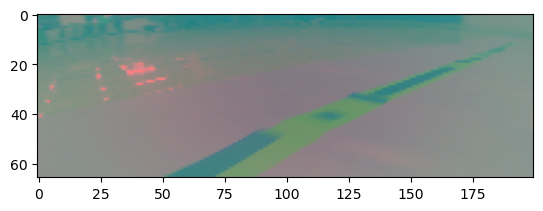

In [31]:

net_batch.eval()
batch_iter = iter(test_batch_loader)
# batch_iter = iter(testloader)
img_list = []
with torch.no_grad():
    for batch_idx, (inputs, target_steering, target_throttle) in enumerate(test_batch_loader):
        inputs = inputs.to(device)
        res = net_batch(inputs)
        print('predicted: throttle ',res[0][0].item(),'steering',res[0][1].item())
        img_list.append(inputs[0].permute(1, 2, 0))
        plt.figure(batch_idx)
        plt.imshow(inputs.cpu()[0].permute(1, 2, 0))
